# CE-40717: Machine Learning

## Student Name: AmirHossein Kargaran Khouzani (stu no: 99201119)

## HW4-MultiLayer Perceptron (MLP)

The following lines of code will load the [MNIST](http://yann.lecun.com/exdb/mnist/) data and turn them
into numpy arrays, you can print their shape if you like.
You can also transform the data as you wish, including seperating
the training data for cross validation.

If you have the data (on google drive or locally) change the root
address accordingly, if you don't, set download=True but you might encounter
some problems downloading the data.

## Import libraries

In [1]:
import torchvision.datasets as ds
import numpy as np
import matplotlib.pyplot as plt

## Import data

In [2]:
data_train = np.array(ds.MNIST(root="./data", train=True, download=True).data)
target_train = np.array(ds.MNIST(root="./data", train=True, download=True).targets)
data_test = np.array(ds.MNIST(root="./data", train=False, download=True).data)
target_test = np.array(ds.MNIST(root="./data", train=False, download=True).targets)

## Reshape data

In [3]:
x_train = data_train.reshape(60000, 784).T
x_test  = data_test.reshape(10000, 784).T
x_train = x_train.astype('float32')
x_test  = x_test.astype('float32')
x_train /= 255 # [0-255] -> [0,1]
x_test  /= 255 # [0-255] -> [0,1]
y_train = np.eye(10)[target_train].T # One-Hot
y_test = np.eye(10)[target_test].T # One-Hot

print("Training x matrix shape", x_train.shape)
print("Testing x matrix shape", x_test.shape)
print("Training y matrix shape", y_train.shape)
print("Training y matrix shape", y_test.shape)

Training x matrix shape (784, 60000)
Testing x matrix shape (784, 10000)
Training y matrix shape (10, 60000)
Training y matrix shape (10, 10000)


## Plot some examples and Test labels

labels: [5 0 4 1 9 2 1 3 1 4]


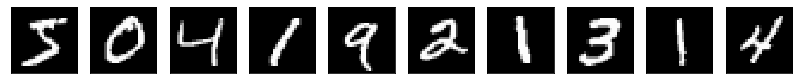

In [4]:
plot_numbers = 10 
plt.figure(1, figsize=(14,3))
for i in range(plot_numbers):
    plt.subplot(1, plot_numbers, i+1, xticks=[], yticks=[])
    plt.imshow(x_train[:,i].reshape(28,28), cmap='gray', interpolation='nearest')
print("labels:", target_train[:plot_numbers])    

### Part1:
Complete the functions of the MLP class to create
a MultiLayer Perceptron

In [5]:
def softMax(x):
    e = np.exp(x)
    p = e/np.sum(e, axis=0)
    return p

class MLP:
    def __init__(self, in_dimensions, hidden_dimensions, out_dimensions, method = "sigmoid"):
        self.w1 = np.random.normal(size=(hidden_dimensions, in_dimensions)) / in_dimensions
        self.b1 = np.random.normal(size=(hidden_dimensions, 1)) / in_dimensions
        self.w2 = np.random.normal(size=(out_dimensions, hidden_dimensions)) / in_dimensions
        self.b2 = np.random.normal(size=(out_dimensions, 1)) / in_dimensions

        self.method = method 

    def activation_function(self, x):
        if self.method == "relu":
            return np.maximum(0,x)
        elif self.method == "tanh":
            return np.tanh(x)
        else:
            return 1./(1.+np.exp(-x))

    def activation_derivation(self, x):
        if self.method == "relu":
            return (x > 0) * 1
        elif self.method == "tanh":
            return 1/(np.cosh(x) ** 2)
        else:
            return np.exp(-x)/(1 + np.exp(-x)) ** 2
            
        
    def cross_entropy(self, y, y_pred, l):
        m = y.shape[1]
        loss = -(1/m) * np.sum(y * np.log(y_pred)) + l/(2 * m) * (np.sum(self.w1 ** 2) + np.sum(self.w2 ** 2))
        return loss

    def forward(self, x):
        # performed a forward pass of the network and return the result
        # Used an activation function for the first layer
        # and softmax activation for the output layer
        z1 = np.matmul(self.w1, x) + self.b1
        a1 = self.activation_function(z1)
        z2 = np.matmul(self.w2, a1) + self.b2
        a2 = softMax(z2)
        return {'z1': z1,
                'a1': a1,
                'z2': z2,
                'a2': a2}


    def backward(self, x, y, forward):
        # performed a backpropagation on the loss value and compute the gradient 
        # w.r.t. every element of the network and retain them (i.e. self.w1_backward)
        m = x.shape[1]
        dz2 = forward['a2'] - y
        dw2 = (1/m) * np.matmul(dz2, forward['a1'].T)
        db2 = (1/m) * np.sum(dz2, axis=1, keepdims=True)
        da1 = np.matmul(self.w2.T, dz2)
        dz1 = da1 * self.activation_derivation(forward['z1'])
        dw1 = (1/m) * np.matmul(dz1, x.T)
        db1 = (1/m) * np.sum(dz1)
        return {'dw1': dw1,
                'db1': db1,
                'dw2': dw2,
                'db2': db2}

    def step(self, gradient, lr, l, m):
        # simply update all the weights using the gradinets computed in backward
        # and the given learning rate with SGD
        # don't forget to use regularization
        self.w1 = self.w1 - lr * gradient['dw1'] - (self.w1 * l * lr)/m
        self.b1 = self.b1 - lr * gradient['db1']
        self.w2 = self.w2 - lr * gradient['dw2'] - (self.w2 * l * lr)/m
        self.b2 = self.b2 - lr * gradient['db2']


### Part2:
Make instances of your network and train them **using l2 regularization and choose the lambda using k-fold cross validation
(set the candidate lambda as you wish)**.

You may choose the hyperparameters (i.e. num of epochs, learning rate etc.)
as you wish. 

Then train a final model on all the training data with the chosen lambda.


In [6]:
n_epochs = 1000 # number of epochs
batch_size = 10000 #batch size =< 60000
lr = 1 # learning rate
k = 3 # number of folds
in_dim = 784 # MNIST has 28*28 images
hidden_dim = 100 # number of hidden dimensions for the hidden layer
out_dim = 10 # MNIST has 10 classes
fold_len = int(data_train.shape[0]/k)
lambdas = [1, 1.5 ,2]
method = "sigmoid"
best_lambda = lambdas[-1]
best_acc = 0

for l in lambdas:
    acc = 0 # accuracy for current lambda
    loss = 0 # loss for current lambda
    for j in range(k):
        temp_loss = []
        temp_acc = []
        model = MLP(in_dim, hidden_dim, out_dim, method)
        total_index = list(range(fold_len*k))
        val_index = list(range(j*fold_len,(j+1)*fold_len))
        fold_train_index = [x for x in total_index if x not in val_index]

        fold_train_set = x_train[:,fold_train_index] # the training data for the current fold
        fold_train_target = y_train[:,fold_train_index] # the training targets for the current fold
        val_set = x_train[:,val_index] # the validation data for the current fold
        val_target = y_train[:,val_index] # the validation targets for the current fold
        val_y = target_train[val_index] # the validation targets for the current fold

        for i in range(n_epochs):
            # train the model on the data with the current lambda
            # shuffle batch indices (choose first batch_size examples)
            indices = np.random.permutation(fold_train_target.shape[1])[:batch_size]
            x, y = fold_train_set[:,indices], fold_train_target[:,indices]
            # forward pass
            forward = model.forward(x)
            # back Prop
            gradient = model.backward(x, y, forward)
            # updating weights
            model.step(gradient, lr, l, x.shape[1])

        # test the model on the current validation data
        forward = model.forward(val_set)
        y_pred = np.argmax(forward['a2'], axis=0)
        fold_acc = np.mean(y_pred == val_y) # current fold accuracy
        fold_loss = model.cross_entropy(val_target, forward['a2'], l) # current fold loss
        temp_acc.append(fold_acc)
        temp_loss.append(fold_loss)


    print(f"Lambda: {l}, hidden_dim: {hidden_dim}, method: {method}")
    loss = np.mean(temp_loss)
    acc = np.mean(temp_acc)
    print("Loss: %.4f Accuracy: %.4f" % (loss, acc))
    if acc > best_acc:
        best_acc = acc
        best_lambda = l

print("Best lambda is", best_lambda, "with %.4f accuracy" % best_acc)

Lambda: 1, hidden_dim: 100, method: sigmoid
Loss: 0.2158 Accuracy: 0.9406
Lambda: 1.5, hidden_dim: 100, method: sigmoid
Loss: 0.2238 Accuracy: 0.9403
Lambda: 2, hidden_dim: 100, method: sigmoid
Loss: 0.2327 Accuracy: 0.9395
Best lambda is 1 with 0.9406 accuracy


### Part3:
Train a final model using the best lambda on all the training data

In [7]:
n_epochs = 1000 # number of epochs
lr = 1 # learning rate
l = best_lambda  # best_lambda
model = MLP(784, 100, 10, 'sigmoid') # new model
train_loss_series = []
test_loss_series = []
train_acc_series = []
test_acc_series = []

for i in range(n_epochs):
    #### training code here ####

    #shuffle batch indices
    indices = np.random.permutation(x_train.shape[1])
    x, y, y_target  = x_train[:,indices], y_train[:,indices], target_train[indices]

    #forward pass train
    forward_train = model.forward(x)
    #acc train
    y_pred_train = np.argmax(forward_train['a2'], axis=0)
    acc_train = np.mean(y_pred_train == y_target)
    #loss train
    loss_train = model.cross_entropy(y, forward_train['a2'], l)
    
    #forward pass test
    forward_test = model.forward(x_test)
    #acc test
    y_pred_test = np.argmax(forward_test['a2'], axis=0)
    acc_test = np.mean(y_pred_test == target_test)
    #loss test
    loss_test = model.cross_entropy(y_test, forward_test['a2'], l)
    
    #back Propagation
    gradient = model.backward(x, y, forward_train)
    #update weights
    model.step(gradient, lr, l, x.shape[1])

    train_loss_series.append(loss_train)
    test_loss_series.append(loss_test)
    train_acc_series.append(acc_train)
    test_acc_series.append(acc_test)

### Part4:

Plot the training loss value and accuracy (mean over all batches each epoch if you're using mini-batches) over epochs
for the final model that is trained on all the training data

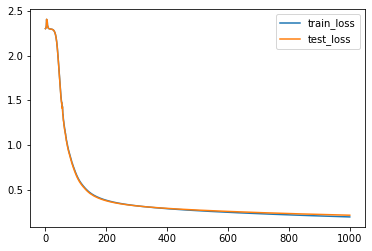

In [8]:
plt.plot(train_loss_series, label='train_loss')
plt.plot(test_loss_series, label='test_loss')
plt.legend()


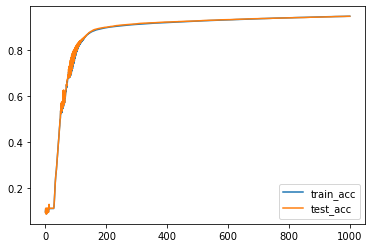

In [9]:
plt.plot(train_acc_series, label='train_acc')
plt.plot(test_acc_series, label='test_acc')
plt.legend()


Use your network on the test set and report the accuracy, you must get at least 70% accuracy on the test set.

In [10]:
acc_test = np.mean(y_pred_test == target_test)
print("Accuracy: %.4f" % acc_test)

Accuracy: 0.9453


Below you can add code cells and improve on the network structure as you see fit (it still must be an MLP), train and test your network and explain why it works better.


## Hyper Parameter over lambda, method, hidden_dim

In [11]:
n_epochs = 1000 # number of epochs
batch_size = 10000 #batch size
lr = 1 # learning rate
k = 3 # number of folds
in_dim = 784 # MNIST has 28*28 images
hidden_dims = [100, 200, 400] # number of hidden dimensions for the hidden layer
out_dim = 10 # MNIST has 10 classes
fold_len = int(data_train.shape[0]/k)
lambdas = [0.5, 1 ,1.5 ,2]
methods = ["sigmoid", "tanh", "relu"]
best_lambda = lambdas[-1]
best_method = methods[-1]
best_hidden_dim = hidden_dims[-1]
best_acc = 0

for hidden_dim in hidden_dims:
    for method in methods:
        for l in lambdas:
            acc = 0 # accuracy for current lambda
            loss = 0 # loss for current lambda
            for j in range(k):
                temp_loss = []
                temp_acc = []
                model = MLP(in_dim, hidden_dim, out_dim, method)
                total_index = list(range(fold_len*k))
                val_index = list(range(j*fold_len,(j+1)*fold_len))
                fold_train_index = [x for x in total_index if x not in val_index]

                fold_train_set = x_train[:,fold_train_index] # the training data for the current fold
                fold_train_target = y_train[:,fold_train_index] # the training targets for the current fold
                val_set = x_train[:,val_index]# the validation data for the current fold
                val_target = y_train[:,val_index]# the validation targets for the current fold
                val_y = target_train[val_index]# the validation targets for the current fold

                for i in range(n_epochs):
                    # train the model on the data with the current lambda
                    # shuffle batch indices (choose first batch_size examples)
                    indices = np.random.permutation(fold_train_target.shape[1])[:batch_size]
                    x, y = fold_train_set[:,indices], fold_train_target[:,indices]
                    # forward pass
                    forward = model.forward(x)
                    # back Prop
                    gradient = model.backward(x, y, forward)
                    # updating weights
                    model.step(gradient, lr, l, x.shape[1])

                # test the model on the current validation data
                forward = model.forward(val_set)
                y_pred = np.argmax(forward['a2'], axis=0)
                fold_acc = np.mean(y_pred == val_y) # current fold accuracy
                fold_loss = model.cross_entropy(val_target, forward['a2'], l) # current fold loss
                temp_acc.append(fold_acc)
                temp_loss.append(fold_loss)


#             print(f"Lambda: {l}, hidden_dim: {hidden_dim}, method: {method}")
            loss = np.mean(temp_loss)
            acc = np.mean(temp_acc)
#             print("Loss: %.4f Accuracy: %.4f" % (loss, acc))
            if acc > best_acc:
                best_acc = acc
                best_lambda = l
                best_hidden_dim = hidden_dim
                best_method = method

In [12]:
n_epochs = 1000 # number of epochs
lr = 1 # learning rate
l = 2  # best_lambda
model = MLP(784, 100, 10, 'relu') # new model

train_loss_series = []
test_loss_series = []
train_acc_series = []
test_acc_series = []

for i in range(n_epochs):
    #### training code here ####

    #shuffle batch indices
    indices = np.random.permutation(x_train.shape[1])[:1000]
    x, y, y_target  = x_train[:,indices], y_train[:,indices], target_train[indices]

    #forward pass train
    forward_train = model.forward(x)
    #acc train
    y_pred_train = np.argmax(forward_train['a2'], axis=0)
    acc_train = np.mean(y_pred_train == y_target)
    #loss train
    loss_train = model.cross_entropy(y, forward_train['a2'], l)
    
    #forward pass test
    forward_test = model.forward(x_test)
    #acc test
    y_pred_test = np.argmax(forward_test['a2'], axis=0)
    acc_test = np.mean(y_pred_test == target_test)
    #loss test
    loss_test = model.cross_entropy(y_test, forward_test['a2'], l)
    
    #back Propagation
    gradient = model.backward(x, y, forward_train)
    #update weights
    model.step(gradient, lr, l, x.shape[1])

    train_loss_series.append(loss_train)
    test_loss_series.append(loss_test)
    train_acc_series.append(acc_train)
    test_acc_series.append(acc_test)

In [13]:
acc_test = np.mean(y_pred_test == target_test)
print("Accuracy: %.4f" % acc_test)

Accuracy: 0.9762
